## Compile images for a figure

Pull downloaded tiff files, process them (add scale bars, merge, and color), and output them as pngs.

We will use the PNGs to compile new supplementary figures.

### Figure components

We will output two essential components.

**Component A**

The first component will be the standard Cell Painting image outlining the difference between the channels.

**Component B**

The second component will be a merged representation from several replicates in four different compounds.

We will use these components in several 

In [1]:
import os
import re
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import skimage.io
import skimage.exposure

from utils.channels import get_channel_map, get_channel_colors
from utils.parse_xml import get_resolution

from utils.image import normalize_image, colorize_image

In [2]:
image_path = "images"
n_replicates = 5

a_scale = 20
b_scale = 200

dose_recode_info = {
    "0": "",
    '1': '0.04 uM',
    '2': '0.12 uM',
    '3': '0.37 uM',
    '4': '1.11 uM',
    '5':'3.33 uM',
    '6':'10 uM'
}

In [3]:
channel_map = get_channel_map()
channels = list(channel_map.values())
channel_colors = get_channel_colors()

channel_map

{'HOECHST 33342': 'DNA',
 'Alexa 488': 'ER',
 '488 long': 'RNA',
 'Alexa 568': 'AGP',
 'Alexa 647': 'Mito'}

In [4]:
# Load url data from file
url_file = pathlib.Path("results", "representative_image_urls.tsv")
url_df = pd.read_csv(url_file, sep="\t")

url_df.head(2)

,image_id,image_url,image_channel,compound,compound_id,dose,median_score,moa,well,plate,xml_plate_folder_name,image_site
0,0514K1F5P1R1,r05c14f05p01-ch1sk1fk1fl1.tiff,HOECHST 33342,kpt-330,ID0,5,0.92348,exportin antagonist,E14,SQ00015157,xml/SQ00015157__2016-04-14T22_48_58-Measurement1,F5
1,0514K1F5P1R2,r05c14f05p01-ch2sk1fk1fl1.tiff,Alexa 488,kpt-330,ID0,5,0.92348,exportin antagonist,E14,SQ00015157,xml/SQ00015157__2016-04-14T22_48_58-Measurement1,F5


## Component A - Standard Example Cell Painting

In [5]:
component_a_df = url_df.head(5)
component_a_df

,image_id,image_url,image_channel,compound,compound_id,dose,median_score,moa,well,plate,xml_plate_folder_name,image_site
0,0514K1F5P1R1,r05c14f05p01-ch1sk1fk1fl1.tiff,HOECHST 33342,kpt-330,ID0,5,0.92348,exportin antagonist,E14,SQ00015157,xml/SQ00015157__2016-04-14T22_48_58-Measurement1,F5
1,0514K1F5P1R2,r05c14f05p01-ch2sk1fk1fl1.tiff,Alexa 488,kpt-330,ID0,5,0.92348,exportin antagonist,E14,SQ00015157,xml/SQ00015157__2016-04-14T22_48_58-Measurement1,F5
2,0514K1F5P1R3,r05c14f05p01-ch3sk1fk1fl1.tiff,488 long,kpt-330,ID0,5,0.92348,exportin antagonist,E14,SQ00015157,xml/SQ00015157__2016-04-14T22_48_58-Measurement1,F5
3,0514K1F5P1R4,r05c14f05p01-ch4sk1fk1fl1.tiff,Alexa 568,kpt-330,ID0,5,0.92348,exportin antagonist,E14,SQ00015157,xml/SQ00015157__2016-04-14T22_48_58-Measurement1,F5
4,0514K1F5P1R5,r05c14f05p01-ch5sk1fk1fl1.tiff,Alexa 647,kpt-330,ID0,5,0.92348,exportin antagonist,E14,SQ00015157,xml/SQ00015157__2016-04-14T22_48_58-Measurement1,F5


In [6]:
# Load image paths per channel
channel_file_dict = {}

for idx, image in component_a_df.iterrows():
    dye = image.image_channel
    channel = channel_map[dye]

    file_name = pathlib.Path(image_path, image.image_url)
    channel_file_dict[channel] = file_name

channel_file_dict

{'DNA': PosixPath('images/r05c14f05p01-ch1sk1fk1fl1.tiff'),
 'ER': PosixPath('images/r05c14f05p01-ch2sk1fk1fl1.tiff'),
 'RNA': PosixPath('images/r05c14f05p01-ch3sk1fk1fl1.tiff'),
 'AGP': PosixPath('images/r05c14f05p01-ch4sk1fk1fl1.tiff'),
 'Mito': PosixPath('images/r05c14f05p01-ch5sk1fk1fl1.tiff')}

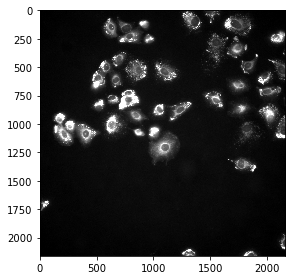

In [7]:
# Read Images
image_dict = {}
for channel in channel_file_dict:
    image_dict[channel] = skimage.io.imread(
        channel_file_dict[channel]
    )

# Show an example image
skimage.io.imshow(normalize_image(image_dict[channel]))

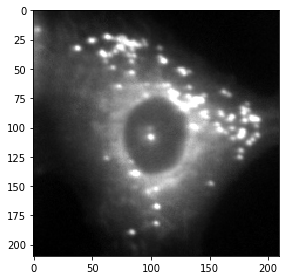

In [8]:
# Crop image to focus on one cell
mindim_row = 980
maxdim_row = 1190
mindim_col = 300
maxdim_col = 510

image_dict_crop = {}
for channel in image_dict:
    image_dict_crop[channel] = image_dict[channel][mindim_row:maxdim_row, mindim_col:maxdim_col]
    
skimage.io.imshow(normalize_image(image_dict[channel][mindim_row:maxdim_row, mindim_col:maxdim_col]))

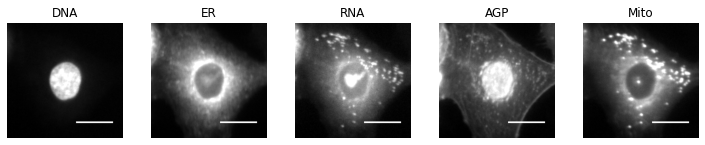

In [9]:
# Plot the combined cropped image
image_tiff_file = channel_file_dict[channel]
xml_file = f"{component_a_df.xml_plate_folder_name[0]}/Images/Index.idx.xml"
resolution = get_resolution(xml_file, image_tiff_file)

scale_bar_length = int(a_scale / resolution) + 1
    
fig, ax = plt.subplots(nrows=1, ncols=len(channels), figsize=(10, 2))
for channel_idx in range(0, len(channels)):
    channel = channels[channel_idx]
    
    image = normalize_image(image_dict_crop[channel].copy())
    image[180:183, 125:125+scale_bar_length] = 255
    
    ax[channel_idx].imshow(image, cmap="gray")
    ax[channel_idx].axis("off")

    ax[channel_idx].set_title(channel)

plt.tight_layout(pad=0)

output_file = os.path.join("pngs", "component_a_cropped_single_cell_multichannel.png")
plt.subplots_adjust(top=0.8)
plt.savefig(output_file, pad_inches=0.2, dpi=500)

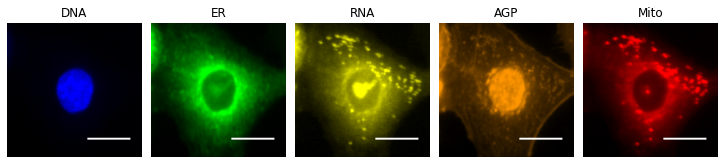

In [10]:
scale_bar_length = int(a_scale / resolution) + 1

# Colorize the image to prepare for merged representation
image_color_dict = {}
for image_key in image_dict_crop:
    img = normalize_image(image_dict_crop[image_key])
    color, color_array = channel_colors[image_key]
    image_color_dict[image_key] = colorize_image(img, color_array)

fig, ax = plt.subplots(nrows=1, ncols=len(channels), figsize=(10, 2))
for channel_idx in range(0, len(channels)):
    channel = channels[channel_idx]
    image_tiff_file = channel_file_dict[channel]

    image = image_color_dict[channel].copy()
    image[180:183, 125:125+scale_bar_length] = 255
        
    ax[channel_idx].imshow(image, cmap="gray")
    ax[channel_idx].axis("off")

    ax[channel_idx].set_title(channel)

plt.tight_layout(pad=0)

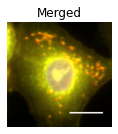

In [11]:
scale_bar_length = int(a_scale / resolution) + 1

combined_image = np.zeros(image_color_dict["DNA"].shape)

for image_key in image_dict:
    combined_image += 2 * image_color_dict[image_key].astype(np.uint16)

combined_image = normalize_image(combined_image)
combined_image[180:183, 125:125+scale_bar_length] = 255

plt.figure(figsize=(2, 2))
plt.imshow(combined_image)
plt.axis("off")
plt.title("Merged")
plt.tight_layout()

output_file = os.path.join("pngs", "component_a_cropped_single_cell_merged.png")
plt.subplots_adjust(top=0.8)
plt.savefig(output_file, pad_inches=0.2, dpi=500)

## Component B

Full FOV of merged channels across replicates for top and bottom replicating compounds

In [12]:
scale_bar_length = int(b_scale / resolution) + 1

image_cpd_dict = {}
for cpd_id in url_df.compound_id.unique():
    # Subset the target images to only the given compound ID
    image_cpd_df = url_df.query("compound_id == @cpd_id")
    
    # Load and transform images
    img_dict = {}
    for idx, image in image_cpd_df.iterrows():
        
        # Extract dye and color information for indexing and transformation
        dye = image.image_channel
        channel = channel_map[dye]
        color, color_array = channel_colors[channel]

        # Extract file names
        file_name = pathlib.Path(image_path, image.plate, image.image_url)

        # Read image
        img = skimage.io.imread(file_name)
        
        # Normalize image
        img = normalize_image(img)
        
        # Colorize the image  
        img_dict[channel] = colorize_image(img, color_array)
    
    # Merge color representations into a single display
    combined_image = np.zeros(img_dict["DNA"].shape)
    for img_key in img_dict:
        combined_image += 2 * img_dict[img_key].astype(np.uint16)

    # Add a scale bar
    combined_image = normalize_image(combined_image)
    combined_image[180:190, 125:125 + scale_bar_length] = 255
    
    # Store in the compound dictionary (there should be 25 images)
    image_cpd_dict[cpd_id] = combined_image

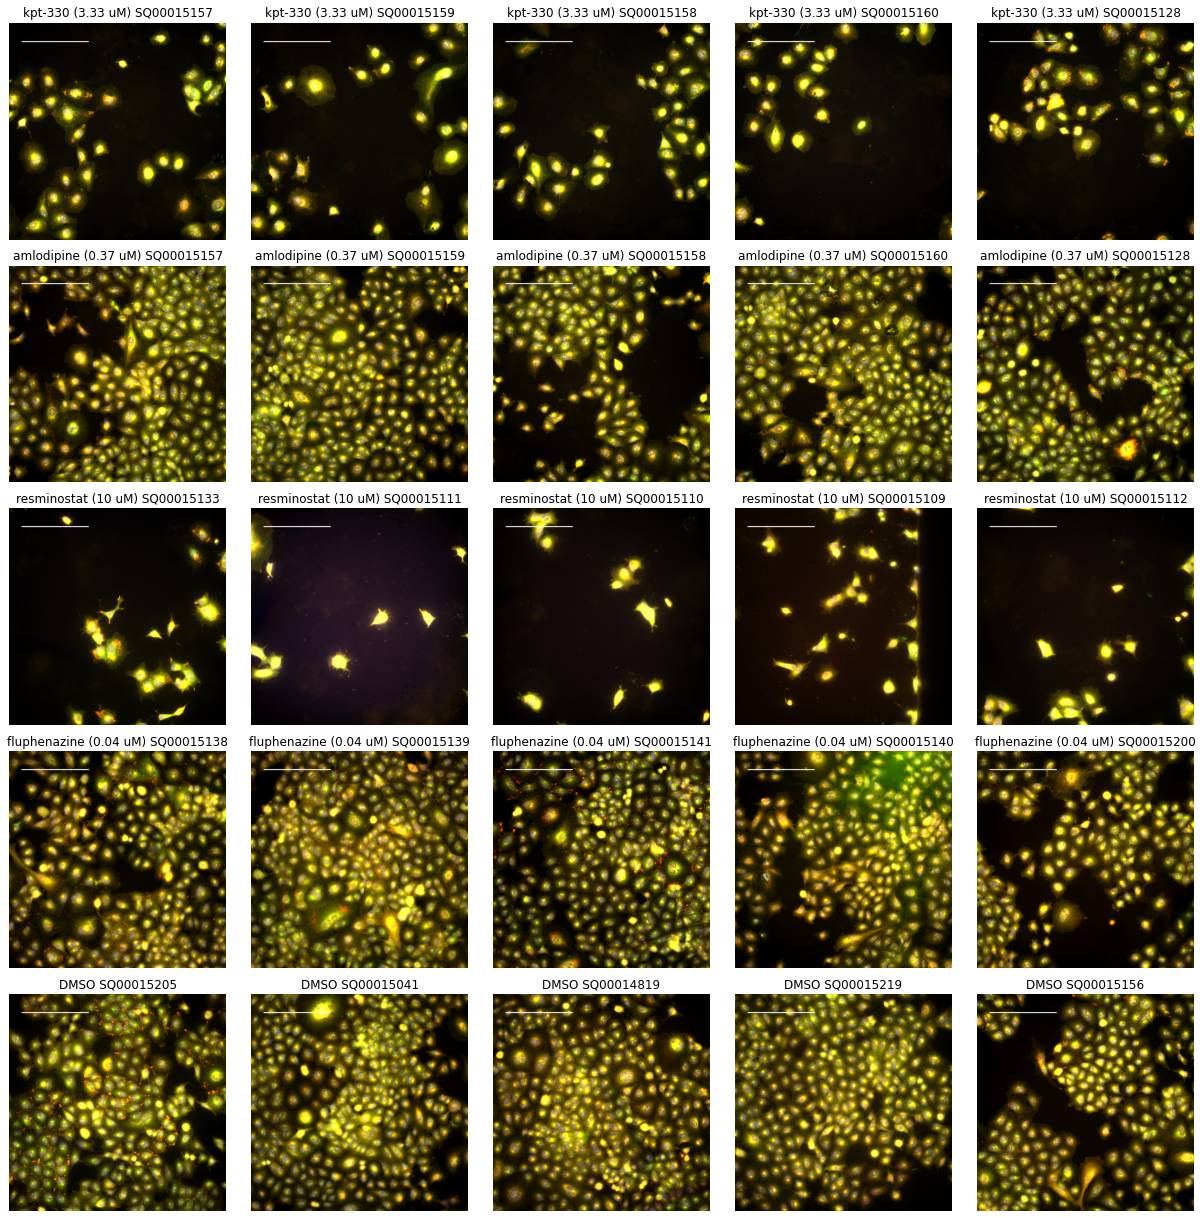

In [13]:
# Output figures paneled by compound replicates
fig, ax = plt.subplots(
    nrows=len(url_df.compound.unique()),
    ncols=n_replicates,
    figsize=(17, 17)
)

for cpd_id in range(0, len(url_df.compound.unique())):
    cpd = url_df.compound.unique()[cpd_id]
    url_cpd_id_subset = url_df.query("compound == @cpd")
    num_cpd_ids = len(url_cpd_id_subset.compound_id.unique())
    for cpd_id_idx in range(0, num_cpd_ids):
        compound_index = url_cpd_id_subset.compound_id.unique()[cpd_id_idx]
        img = image_cpd_dict[compound_index]
        
        dose = dose_recode_info[str(url_cpd_id_subset.dose.unique().tolist()[0])]
        plate = url_cpd_id_subset.plate.unique().tolist()[cpd_id_idx]

        ax[cpd_id][cpd_id_idx].imshow(img, cmap="gray")
        ax[cpd_id][cpd_id_idx].axis("off")
        if cpd == "DMSO":
            title = f"{cpd} {plate}"
        else:
            title = f"{cpd} ({dose}) {plate}"
        ax[cpd_id][cpd_id_idx].set_title(title)
    
plt.tight_layout(pad=1)
output_file = os.path.join("pngs", "full", f"combined_component_b_full_merged.png")
plt.savefig(output_file, pad_inches=0.2, dpi=500)
plt.show()

In [ ]:
# Output all individual figures
for cpd_id in image_cpd_dict:
    img = image_cpd_dict[cpd_id]
    cpd_info = url_df.query("compound_id == @cpd_id")
    
    compound = cpd_info.compound.tolist()[0]
    plate = cpd_info.plate.tolist()[0]
    
    dose = dose_recode_info[str(cpd_info.dose.tolist()[0])]
    
    plt.figure(figsize=(7, 5))
    plt.imshow(image_cpd_dict[cpd_id])
    plt.axis("off")
    plt.title(f"{compound} ({dose}) {plate}")
    plt.tight_layout()
    
    output_file = os.path.join("pngs", "full", f"component_b_full_merged_{compound}_{plate}.png")
    plt.subplots_adjust(top=0.8)
    plt.savefig(output_file, pad_inches=0.2, dpi=500)
    plt.close()